<a href="https://colab.research.google.com/github/sharath2004-tech/cardiac-disease-detection/blob/main/cardiac%20disease%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb


import wfdb
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 5.6 MB/s eta 0:00:00


In [2]:
wfdb.dl_database(
    'mitdb',
    dl_dir='mitdb',
    keep_subdirs=True
)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [3]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

record = wfdb.rdrecord('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')

signal = record.p_signal[:,0]   # use first channel
r_peaks = annotation.sample
labels = annotation.symbol

print("Signal shape:", signal.shape)
print("Total beats:", len(r_peaks))

Signal shape: (650000,)
Total beats: 2274


In [4]:
beats = []
beat_labels = []

for i in range(len(r_peaks)):
    start = r_peaks[i] - 90
    end = r_peaks[i] + 90

    if start > 0 and end < len(signal):
        beat = signal[start:end]
        beats.append(beat)
        beat_labels.append(labels[i])

beats = np.array(beats)
print("Beats shape:", beats.shape)

Beats shape: (2271, 180)


In [5]:
AAMI_map = {
    'N':'N','L':'N','R':'N','e':'N','j':'N',
    'A':'S','a':'S','J':'S','S':'S',
    'V':'V','E':'V',
    'F':'F'
}

class_to_int = {'N':0,'S':1,'V':2,'F':3}

In [6]:
# Standard DS1 (Train) and DS2 (Test) split used in research

train_records = [
    '101','106','108','109','112','114','115','116',
    '118','119','122','124','201','203','205','207',
    '208','209','215','220','223','230'
]

test_records = [
    '100','103','105','111','113','117','121','123',
    '200','202','210','212','213','214','219','221',
    '222','228','231','232','233','234'
]

print("Train records:", len(train_records))
print("Test records:", len(test_records))

# Safety check (no leakage)
print("Overlap:", set(train_records) & set(test_records))

Train records: 22
Test records: 22
Overlap: set()


In [7]:
def extract_beats(record_list):
    beats = []
    labels = []

    for rec in record_list:
        print(f"Processing record {rec}...")

        record = wfdb.rdrecord(f'mitdb/{rec}')
        annotation = wfdb.rdann(f'mitdb/{rec}', 'atr')

        signal = record.p_signal[:, 0]   # Use first channel
        r_peaks = annotation.sample
        symbols = annotation.symbol

        for i in range(len(r_peaks)):
            start = r_peaks[i] - 90
            end = r_peaks[i] + 90

            if start > 0 and end < len(signal):
                label = symbols[i]

                if label in AAMI_map:
                    beat = signal[start:end]

                    # Per-beat normalization
                    mean = np.mean(beat)
                    std = np.std(beat)
                    beat = (beat - mean) / (std + 1e-8)

                    beats.append(beat)
                    labels.append(class_to_int[AAMI_map[label]])

    return np.array(beats), np.array(labels)

In [8]:
X_train, y_train = extract_beats(train_records)
X_test, y_test = extract_beats(test_records)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

import numpy as np
print("Unique classes in train:", np.unique(y_train))

Processing record 101...
Processing record 106...
Processing record 108...
Processing record 109...
Processing record 112...
Processing record 114...
Processing record 115...
Processing record 116...
Processing record 118...
Processing record 119...
Processing record 122...
Processing record 124...
Processing record 201...
Processing record 203...
Processing record 205...
Processing record 207...
Processing record 208...
Processing record 209...
Processing record 215...
Processing record 220...
Processing record 223...
Processing record 230...
Processing record 100...
Processing record 103...
Processing record 105...
Processing record 111...
Processing record 113...
Processing record 117...
Processing record 121...
Processing record 123...
Processing record 200...
Processing record 202...
Processing record 210...
Processing record 212...
Processing record 213...
Processing record 214...
Processing record 219...
Processing record 221...
Processing record 222...
Processing record 228...


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import random

class ECGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        beat = self.X[idx].clone()

        if self.augment:
            # Gaussian noise (stronger, more frequent)
            if random.random() > 0.3:
                noise = torch.randn_like(beat) * random.uniform(0.01, 0.05)
                beat = beat + noise

            # Amplitude scaling (wider range)
            if random.random() > 0.3:
                scale = random.uniform(0.85, 1.15)
                beat = beat * scale

            # Time shifting (larger shifts)
            if random.random() > 0.3:
                shift = random.randint(-15, 15)
                beat = torch.roll(beat, shift, dims=-1)

            # Baseline wander (stronger)
            if random.random() > 0.3:
                baseline = torch.sin(torch.linspace(0, random.uniform(3, 5)*3.14159, beat.size(-1))) * random.uniform(0.03, 0.08)
                beat = beat + baseline.unsqueeze(0)
            
            # Random smoothing
            if random.random() > 0.5:
                kernel_size = random.choice([3, 5])
                beat = F.avg_pool1d(beat.unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze(0)

        return beat, self.y[idx]

In [10]:
train_dataset = ECGDataset(X_train, y_train, augment=True)
test_dataset = ECGDataset(X_test, y_test, augment=False)

# Optimized batch size
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [11]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

Class 0: 45856
Class 1: 944
Class 2: 3788
Class 3: 414


In [12]:
# Apply SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE

print("\n" + "="*50)
print("APPLYING SMOTE OVERSAMPLING")
print("="*50)
print("Before SMOTE:")
unique_before, counts_before = np.unique(y_train, return_counts=True)
for u, c in zip(unique_before, counts_before):
    print(f"  Class {u}: {c}")

# Apply SMOTE with aggressive sampling strategy
# Target: Bring minority classes closer to majority class
smote = SMOTE(sampling_strategy={
    1: 35000,  # S: from 944 to 35,000 (MUCH more)
    2: 30000,  # V: from 3,788 to 30,000 (doubled)
    3: 25000   # F: from 414 to 25,000 (MUCH more)
}, random_state=42, k_neighbors=5)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
for u, c in zip(unique_after, counts_after):
    print(f"  Class {u}: {c}")
print(f"\nTotal samples: {len(y_train_balanced):,}")
print("="*50)

# Use balanced data
X_train = X_train_balanced
y_train = y_train_balanced


APPLYING SMOTE OVERSAMPLING
Before SMOTE:
  Class 0: 45856
  Class 1: 944
  Class 2: 3788
  Class 3: 414

After SMOTE:
  Class 0: 45856
  Class 1: 35000
  Class 2: 30000
  Class 3: 25000

Total samples: 135,856


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Manual class weights - BOOST minority classes aggressively
# Even with SMOTE, we need strong weights for S and F
alpha = torch.tensor([
    0.5,   # N: Reduce weight (it's still majority after SMOTE)
    3.0,   # S: High weight (was performing poorly)
    1.0,   # V: Moderate (performing well)
    5.0    # F: VERY high weight (worst performer)
], dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = alpha.to(device)

print("Class weights:", alpha)

print(f"\nManual Class Weights: {alpha}")

Class weights: tensor([0.5000, 3.0000, 1.0000, 5.0000], device='cuda:0')

Manual Class Weights: tensor([0.5000, 3.0000, 1.0000, 5.0000], device='cuda:0')


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)


class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv1d(channels, channels // 8, 1)
        self.key = nn.Conv1d(channels, channels // 8, 1)
        self.value = nn.Conv1d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, channels, length = x.size()

        q = self.query(x).view(batch, -1, length).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, length)
        v = self.value(x).view(batch, -1, length)

        attention = torch.bmm(q, k)
        attention = F.softmax(attention / math.sqrt(channels // 8), dim=-1)

        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch, channels, length)

        return self.gamma * out + x


class ECGResNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.layer2 = ResidualBlock(32, 64, dropout=0.2)
        self.layer3 = ResidualBlock(64, 128, dropout=0.3)
        self.layer4 = ResidualBlock(128, 256, dropout=0.3)
        self.layer5 = ResidualBlock(256, 256, dropout=0.4)

        self.attention = SelfAttention(256)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(512, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.attention(x)

        # Concatenate avg and max pooling
        avg_pool = self.global_pool(x).squeeze(-1)
        max_pool = self.global_max_pool(x).squeeze(-1)
        x = torch.cat([avg_pool, max_pool], dim=1)

        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGResNet().to(device)

# Lower learning rate with stronger weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-4)

# Better scheduler: CosineAnnealingLR for smooth decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=50, eta_min=1e-6
)

print("Using device:", device)
print("Model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Using device: cuda
Model parameters: 1596869


In [16]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight

    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.view(-1, 1), 1)
        one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_class
        log_prb = F.log_softmax(pred, dim=1)

        if self.weight is not None:
            loss = -(one_hot * log_prb).sum(dim=1)
            loss = (loss * self.weight[target]).mean()
        else:
            loss = -(one_hot * log_prb).sum(dim=1).mean()
        return loss

criterion = LabelSmoothingCrossEntropy(smoothing=0.1, weight=alpha)

def mixup_data(x, y, alpha=0.2):
    '''Apply Mixup augmentation'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    best_val_acc = 0.0
    patience_counter = 0
    warmup_epochs = 5
    base_lr = 0.0005

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        # Warmup learning rate
        if epoch < warmup_epochs:
            lr = base_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # DISABLE Mixup for minority classes (S=1, F=3)
            # Only apply to majority classes to avoid diluting rare patterns
            has_minority = torch.any((targets == 1) | (targets == 3))
            
            if random.random() > 0.7 and not has_minority:
                # Apply Mixup only 30% of time, and only for batches without S or F
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.2)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_acc = 100 * val_correct / val_total
        
        # Step scheduler after warmup
        if epoch >= warmup_epochs:
            scheduler.step()

        # Track best model and save checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
            print(f"✓ Saved new best model (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}% "
              f"Best Val: {best_val_acc:.2f}% "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping with more patience
        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
    
    # Load best model
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

In [17]:
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50)

✓ Saved new best model (Val Acc: 86.53%)
Epoch [1/50] Train Acc: 91.69% Val Acc: 86.53% Best Val: 86.53% LR: 0.000100
Epoch [2/50] Train Acc: 95.34% Val Acc: 82.87% Best Val: 86.53% LR: 0.000200
Epoch [3/50] Train Acc: 96.37% Val Acc: 85.44% Best Val: 86.53% LR: 0.000300
✓ Saved new best model (Val Acc: 89.81%)
Epoch [4/50] Train Acc: 97.11% Val Acc: 89.81% Best Val: 89.81% LR: 0.000400
Epoch [5/50] Train Acc: 97.43% Val Acc: 81.93% Best Val: 89.81% LR: 0.000500
Epoch [6/50] Train Acc: 97.77% Val Acc: 86.55% Best Val: 89.81% LR: 0.000500
Epoch [7/50] Train Acc: 98.08% Val Acc: 85.55% Best Val: 89.81% LR: 0.000498
Epoch [8/50] Train Acc: 98.17% Val Acc: 84.17% Best Val: 89.81% LR: 0.000496
Epoch [9/50] Train Acc: 98.34% Val Acc: 86.57% Best Val: 89.81% LR: 0.000492
Epoch [10/50] Train Acc: 98.44% Val Acc: 78.79% Best Val: 89.81% LR: 0.000488
Epoch [11/50] Train Acc: 98.46% Val Acc: 84.57% Best Val: 89.81% LR: 0.000482
Epoch [12/50] Train Acc: 98.49% Val Acc: 81.47% Best Val: 89.81% LR: 


DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

          N (Normal)     0.9394    0.9481    0.9437     44246
S (Supraventricular)     0.0398    0.0272    0.0323      1837
     V (Ventricular)     0.7661    0.8168    0.7906      3220
          F (Fusion)     0.0000    0.0000    0.0000       388

            accuracy                         0.8981     49691
           macro avg     0.4363    0.4480    0.4417     49691
        weighted avg     0.8876    0.8981    0.8927     49691



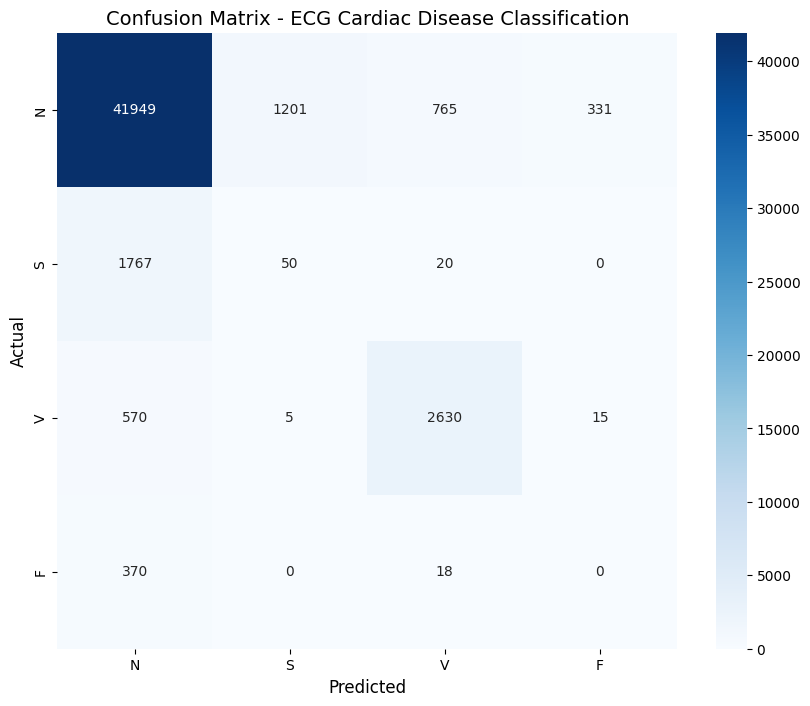

N (Normal): 94.81% (41949/44246)
S (Supraventricular): 2.72% (50/1837)
V (Ventricular): 81.68% (2630/3220)
F (Fusion): 0.00% (0/388)


In [18]:
# Evaluate model performance per class
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_targets, all_preds, 
                            target_names=['N (Normal)', 'S (Supraventricular)', 'V (Ventricular)', 'F (Fusion)'],
                            digits=4))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['N', 'S', 'V', 'F'],
            yticklabels=['N', 'S', 'V', 'F'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - ECG Cardiac Disease Classification', fontsize=14)
plt.show()

# Per-class accuracy
for i, class_name in enumerate(['N (Normal)', 'S (Supraventricular)', 'V (Ventricular)', 'F (Fusion)']):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = 100 * class_correct / class_total if class_total > 0 else 0
    print(f"{class_name}: {class_acc:.2f}% ({class_correct}/{class_total})")